# Setup

## Installs

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

import gpxpy
import folium

In [2]:
GPX_FILE_PATH = '../gpx/'
HARD_SLOPE_THRESHOLD = 0.2 # Threshold to consider a section as hard

colors = {
    'main': '#f53b57',
    'secondary': '#3c40c6',
    'tertiary': '#ffdd59',
}

In [3]:
plt.style.use('ggplot')

# Processing the GPX files

In [21]:
# Read the GPX file
gpx_file_name = 'indomit-saobentosdosapucai-35-2024.gpx'
full_gpx_file_path = os.path.join(GPX_FILE_PATH, gpx_file_name)
gpx_file = gpxpy.parse(open(full_gpx_file_path))

# Only extract the first track and segment
track = gpx_file.tracks[0]
segment = track.segments[0]
points = segment.points

# Extract information from points
coordinates = np.array([[point.latitude, point.longitude, point.elevation] for point in points]) #@!delete
df = (
    pd.DataFrame(
        coordinates,
        columns=['latitude', 'longitude', 'elevation']
    )
    .assign(
        # We add a 0 at the beginning to match the length of the DF
        elevation_diff=lambda x: np.concatenate(
            [[0], np.diff(x['elevation'])],
        )
    )
)

# Calculate the cumulative distances and slopes
distance_between_points_3d = np.zeros(len(points) - 1)
distance_between_points_2d = np.zeros(len(points) - 1)

for i in range(0, len(points) - 1):
    distance_between_points_3d[i] = gpxpy.geo.distance(
        df.iloc[i]['latitude'],  # latitude1
        df.iloc[i]['longitude'],  # longitude1
        df.iloc[i]['elevation'],  # elevation1
        df.iloc[i+1]['latitude'],   # latitude2
        df.iloc[i+1]['longitude'],   # longitude2
        df.iloc[i+1]['elevation'],    # elevation2
    )

    distance_between_points_2d[i] = gpxpy.geo.distance(
        df.iloc[i]['latitude'],  # latitude1
        df.iloc[i]['longitude'],  # longitude1
        0, # Set elevation to 0 for 2D distance
        df.iloc[i+1]['latitude'],   # latitude2
        df.iloc[i+1]['longitude'],   # longitude2
        0, # Set elevation to 0 for 2D distance
    )

# Bin the slopes - Define bin sizes and labels
slope_bins = np.arange(-1, 1, 0.1).round(2)
slope_bin_labels = [f"{round(100*slope_bins[i])} → {round(100*slope_bins[i+1])}%" for i in range(len(slope_bins) - 1)]

df = (
    df
    .assign(
        distance_between_points_3d=np.concatenate(
            [[0], distance_between_points_3d]
        ),
        distance_between_points_2d=np.concatenate(
            [[0], distance_between_points_2d]
        ),
        # Calculate cumulative distance and convert to km
        cum_distance_3d_km=np.concatenate(
            [[0], np.cumsum(distance_between_points_3d)/1000]
        ),
        cum_distance_2d_km=np.concatenate(
            [[0], np.cumsum(distance_between_points_2d)/1000]
        ),
        # # Calculate slope gradients
        slope_gradient=lambda x: x['elevation_diff']/x['distance_between_points_2d'],
        # Bin the slopes
        slope_bin=lambda x: pd.cut(
            x['slope_gradient'] + 0.0001,
            bins=slope_bins,
            right=False,
            labels=slope_bin_labels
        ),
        hard_slope=lambda x: abs(x['slope_gradient']) > HARD_SLOPE_THRESHOLD
    )
    .fillna(
        {
            'slope_gradient': 0,
            'slope_bin': '0 → 10%',
        }
    )
)

In [22]:
df

,latitude,longitude,elevation,elevation_diff,distance_between_points_3d,distance_between_points_2d,cum_distance_3d_km,cum_distance_2d_km,slope_gradient,slope_bin,hard_slope
0,-22.68910,-45.73350,873.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0 → 10%,False
1,-22.68902,-45.73320,873.0,0.0,32.072588,32.072588,0.032073,0.032073,0.000000,0 → 10%,False
2,-22.68901,-45.73276,873.0,0.0,45.203777,45.203777,0.077276,0.077276,0.000000,0 → 10%,False
3,-22.68903,-45.73243,873.0,0.0,33.965600,33.965600,0.111242,0.111242,0.000000,0 → 10%,False
4,-22.68871,-45.73222,873.0,0.0,41.642788,41.642788,0.152885,0.152885,0.000000,0 → 10%,False
...,...,...,...,...,...,...,...,...,...,...,...
994,-22.68113,-45.73111,968.0,0.0,28.584540,28.584540,37.098964,36.769149,0.000000,0 → 10%,False
995,-22.68111,-45.73082,971.0,3.0,30.019448,29.869169,37.128983,36.799019,0.100438,10 → 20%,False
996,-22.68092,-45.73061,978.0,7.0,31.009418,30.209005,37.159993,36.829228,0.231719,20 → 30%,True
997,-22.68069,-45.73037,983.0,5.0,35.891359,35.541380,37.195884,36.864769,0.140681,10 → 20%,False


# Plot - Map

In [5]:
# Calculate the center of the route (based on the df)
center_coordinates = np.mean(
    df[['latitude', 'longitude']].values,
    axis=0
)

# Get basic statistics of the route
total_distance = segment.length_3d() # Total distance in meters
total_elevation_gain = segment.get_uphill_downhill().uphill
total_elevation_loss = segment.get_uphill_downhill().downhill

# Bounds of the route
min_lat = df['latitude'].min()
max_lat = df['latitude'].max()
min_lon = df['longitude'].min()
max_lon = df['longitude'].max()

# Create map with auto zoom based on bounds
map = folium.Map(
    location=center_coordinates,
    zoom_start=12,
)

# Fit bounds to the route
map.fit_bounds(
    [
        [min_lat, min_lon],  # Southwest corner
        [max_lat, max_lon]   # Northeast corner
    ]
)

# Add the route to the map
folium.PolyLine(
    df[['latitude', 'longitude']].values,
    weight=5,
    color=colors['main'],
    opacity=0.8
).add_to(map)

# Add the start and end points to the map
folium.Marker(
    location=df.iloc[0][['latitude', 'longitude']].values,
    icon=folium.Icon(color='green', icon='circle'),
).add_to(map)

folium.Marker(
    location=df.iloc[-1][['latitude', 'longitude']].values,
    icon=folium.Icon(color='red', icon='circle'),
).add_to(map)

# Display the map
map

In [6]:
print(f"Total distance: {total_distance/1000:.1f} km")
print(f"Total elevation gain: {round(total_elevation_gain):,} m")
print(f"Total elevation loss: {round(total_elevation_loss):,} m")
print(f"Total elevation gain / distance: {total_elevation_gain/total_distance:.3f}")

Total distance: 37.2 km
Total elevation gain: 1,850 m
Total elevation loss: 1,738 m
Total elevation gain / distance: 0.050


# Plot - Elevation profile

In [10]:
# Create the plot
fig = px.line(
    x=df['cum_distance_3d_km'],
    y=df['elevation'],
    title='Elevation Profile',
    labels={
        'x': 'Distance (km)',
        'y': 'Elevation (m)'
    }
)

fig.update_traces(
    line_color=colors['main'],
    line_width=2,
    fill='tonexty',
    fillcolor=f"rgba{tuple(int(colors['main'].lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) + (0.1,)}",
    mode='lines',
)

fig.update_layout(
    showlegend=False,
    plot_bgcolor='white',
    width=900,
    height=400,
    hoverdistance=100,     # Maximum distance to show hover effect
    spikedistance=100,     # Maximum distance to show spike
    yaxis=dict(
        range=[df['elevation'].min() - 50, df['elevation'].max() + 50],
        tickformat='.0f',  # Format y-axis ticks to 1 decimal place
        showline=True,
        showgrid=True,
        gridcolor='lightgrey',
        showspikes=True,         # Show spike line
        spikecolor=colors['main'],
        spikesnap='data',      # Spike snaps to data points
        spikemode='across',      # Spike goes across the plot
        spikethickness=1
    ),
    xaxis=dict(
        tickformat='.1f',  # Format x-axis ticks to 2 decimal places
        showline=True,
        showgrid=True,
        gridcolor='lightgrey',
        spikemode='across',
        spikesnap='data',
        spikethickness=1,
        spikecolor=colors['main']
    ),
    yaxis_title='Elevation (m)',
    xaxis_title='Distance (km)',
)

fig.show()

# Plot - Slope gradients

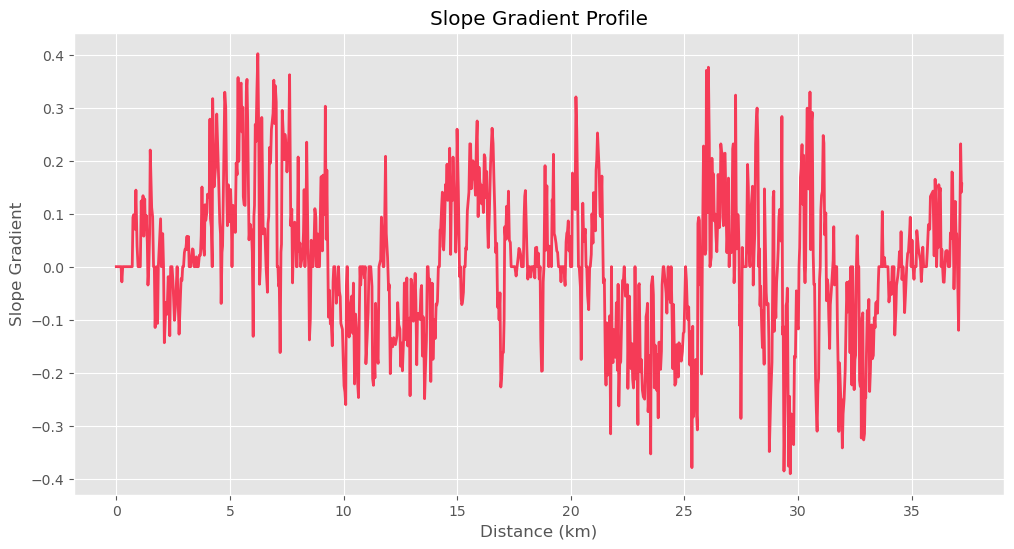

In [16]:
# Plot the slope gradients
plt.figure(figsize=(12, 6))
plt.plot(
    df['cum_distance_3d_km'],
    df['slope_gradient'],
    color=colors['main'],
    linewidth=2
)
plt.xlabel('Distance (km)')
plt.ylabel('Slope Gradient')
plt.title('Slope Gradient Profile')
plt.grid(True)
plt.show()

% of slopes with gradient > 0.2: 16.2%


/var/folders/q3/cbb_kmc13v1cvh7qwcdm3xs40000gn/T/ipykernel_45767/3290867969.py:4: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



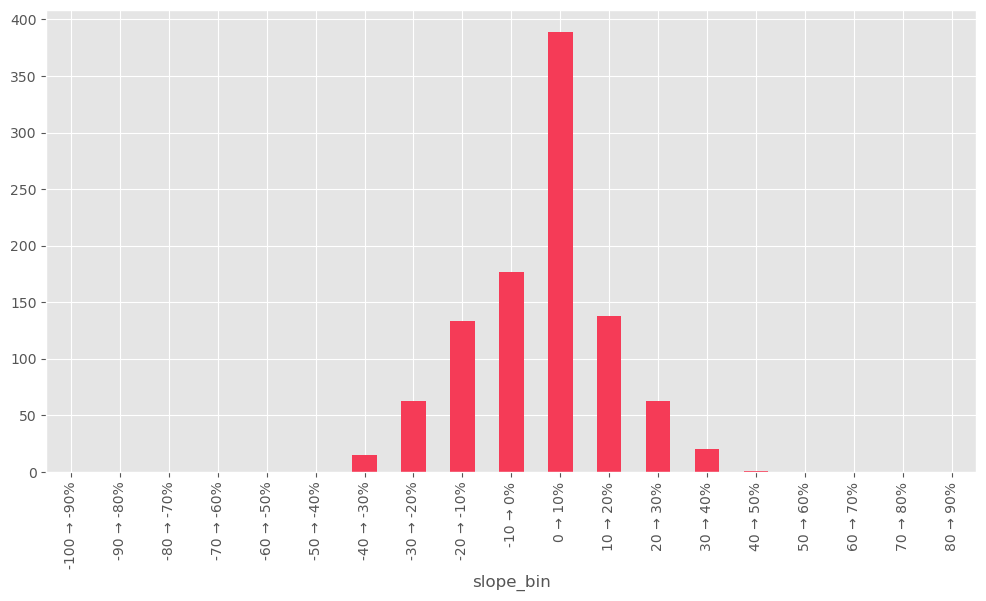

In [23]:
# Plot a histogram of the slope classifications
slope_df = (
    df
    .groupby('slope_bin')
    .size()
)

# % of hard slopes
hard_slope_perc = (
    (
        df
        .groupby('hard_slope')
        .size()/len(df)
    )
    .loc[True]
)

print(f"% of slopes with gradient > {HARD_SLOPE_THRESHOLD}: {100*hard_slope_perc:.1f}%")
# Plot the histogram
(
    slope_df
    .plot(
        kind='bar',
        color=colors['main'],
        figsize=(12, 6),
    )
);